In [1]:
import os
import glob

image_types = os.listdir('vehicles/')
cars = []
for imtype in image_types:
    cars.extend(glob.glob('vehicles/'+imtype+'/*'))
n_cars = len(cars)
    
print('Number of Vehicle Images found:', n_cars)
with open('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
image_types = os.listdir('non-vehicles/')
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob('non-vehicles/'+imtype+'/*'))

n_notcars = len(notcars)    
print('Number of Non-Vehicle Images found:', n_notcars)
with open('notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("Load Completed")

Load Completed


In [3]:
# Extraction functions
      
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    colour1 = cv2.resize(img[:,:,0], size).ravel()
    colour2 = cv2.resize(img[:,:,1], size).ravel() 
    colour3 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    return np.hstack((colour1, colour2, colour3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32): #bins_range=(0, 256) for jpg image
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def colour_convert(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image) 
    
    return feature_image    

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = colour_convert(image, cspace=cspace)
            
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
       
        if hist_feat:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            # Append the new feature vector to the features list
            file_features.append(hist_features)
            
        if hog_feat:
            # Apply get_hog_features() with vis=False, feature_vec=True
            if hog_channel == "ALL":
                hog_features = []
                for channel in range(f_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True))
                hog_features = np.concatenate(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

In [5]:
# Define a function for plotting multiple images
def visualise(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [6]:
# Define function to explore the colourspace and HOG features
def explore(image, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2):
    
    imgs = []
    imgs.append(image)
    
    feature_image = colour_convert(image, cspace=cspace)
    
    for i in range(feature_image.shape[2]):
        imgs.append(feature_image[:,:,i])
        hog_feature, hog_img = get_hog_features(feature_image[:,:,i], orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=False)
        imgs.append(hog_img)
    
    return imgs       

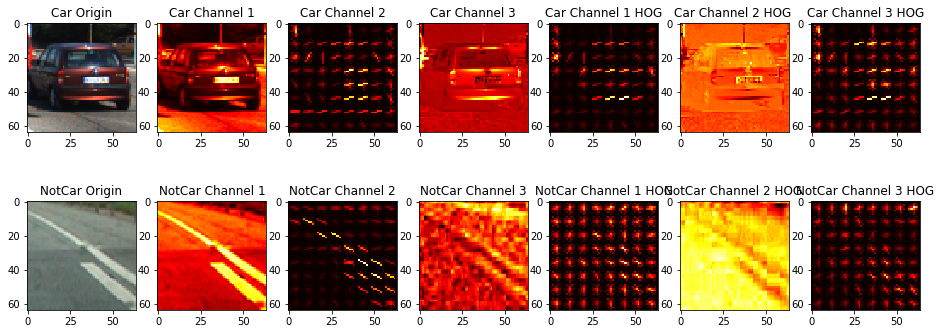

In [7]:
%matplotlib inline

# Explore HOG and Color spaces
colour_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

car_ind = np.random.randint(0, n_cars)
notcar_ind = np.random.randint(0, n_notcars)

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

images = explore(car_image, cspace=colour_spaces[5])
images.extend(explore(notcar_image, cspace=colour_spaces[5]))

titles = ['Car Origin', 'Car Channel 1', 'Car Channel 2', 'Car Channel 3', 'Car Channel 1 HOG', 'Car Channel 2 HOG ', 'Car Channel 3 HOG',
          'NotCar Origin', 'NotCar Channel 1', 'NotCar Channel 2', 'NotCar Channel 3', 'NotCar Channel 1 HOG', 'NotCar Channel 2 HOG ', 'NotCar Channel 3 HOG']
fig = plt.figure(figsize=(16,6))
visualise(fig, 2, 7, images, titles)

In [8]:
# Define feature parameters
colour_space = 'YCrCb',
orient = 11
pix_per_cell = 16 #8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = False
hog_feat = False

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, n_cars, n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_feature = extract_features(test_cars, cspace=colour_space,
                              spatial_size=spatial_size, hist_bins=hist_bins,
                              orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block,
                              hog_channel=hog_channel, spatial_feat=spatial_feat,
                              hist_feat=hist_feat, hog_feat=hog_feat)

notcar_feature = extract_features(test_notcars, cspace=colour_space,
                              spatial_size=spatial_size, hist_bins=hist_bins,
                              orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block,
                              hog_channel=hog_channel, spatial_feat=spatial_feat,
                              hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t,  'Seconds to extract features...')

29.88398790359497 Seconds to extract features...


In [9]:
x = np.vstack((car_feature, notcar_feature)).astype(np.float64)

x_scaler = StandardScaler().fit(x)

scaled_x = x_scaler.transform(x)

y = np.hstack((np.ones(len(car_feature)), np.zeros(len(notcar_feature))))

rand_state = np.random.randint(0, 100)

x_train, x_test, y_train, y_test = train_test_split(
scaled_x, y, test_size = 0.2, random_state = rand_state)

print("Training and test data are ready")
print("Feature vector length:", len(x_train[0]))

Training and test data are ready
Feature vector length: 768


In [10]:
svc = LinearSVC()
t=time.time()
svc.fit(x_train, y_train)
accuracy = svc.score(x_test, y_test)

print(round(time.time()-t,2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(accuracy, 4))

1.01 Seconds to train SVC...
Test Accuracy of SVC =  0.8975


In [11]:
# Define a function to extract features from a single image window
def single_img_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a list to append feature vectors to
    img_features = []
    # Apply color conversion if other than 'RGB'    
    feature_image=colour_convert(image, cspace=cspace) 
        
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append the new feature vector to the features list
        img_features.append(hist_features)
    
    if hog_feat == True:
        #hog_features = []
        if hog_channel == "ALL":
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
                hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
    
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows    
        

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, scale):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = colour_convert(img_tosearch, 'YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = x_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = x_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

print("Defined")

Defined


In [ ]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_n in range(1, labels[1]+1):
        nonzero = (labels[0] == car_n).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.maz(nonzerox), (np.max(nonzeroy))))
        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

[[ 0.          0.01568628  0.09803922]
 [ 0.01568628  0.13333334  0.23529412]
 [ 0.20392157  0.38039216  0.53333336]
 ..., 
 [ 0.33725491  0.24313726  0.21960784]
 [ 0.28235295  0.18431373  0.16862746]
 [ 0.28627452  0.21176471  0.1882353 ]]


D:\Program\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


0.2140214443206787 seconds to process one image searching 819 windows
[[ 0.01568628  0.09019608  0.18039216]
 [ 0.07843138  0.12941177  0.20392157]
 [ 0.04705882  0.13725491  0.27058825]
 ..., 
 [ 0.3137255   0.22745098  0.20392157]
 [ 0.19607843  0.12156863  0.10588235]
 [ 0.23137255  0.16078432  0.14509805]]
0.1990199089050293 seconds to process one image searching 819 windows
[[ 0.01176471  0.13725491  0.21960784]
 [ 0.00784314  0.13333334  0.21568628]
 [ 0.12941177  0.28627452  0.3882353 ]
 ..., 
 [ 0.29411766  0.23137255  0.23137255]
 [ 0.22352941  0.15294118  0.14509805]
 [ 0.24705882  0.16470589  0.16078432]]
0.18301820755004883 seconds to process one image searching 819 windows
[[ 0.          0.04705882  0.10980392]
 [ 0.08235294  0.15686275  0.21568628]
 [ 0.04313726  0.16078432  0.25490198]
 ..., 
 [ 0.29411766  0.21960784  0.2       ]
 [ 0.16862746  0.08627451  0.06666667]
 [ 0.13333334  0.09411765  0.09019608]]
0.19501948356628418 seconds to process one image searching 819 

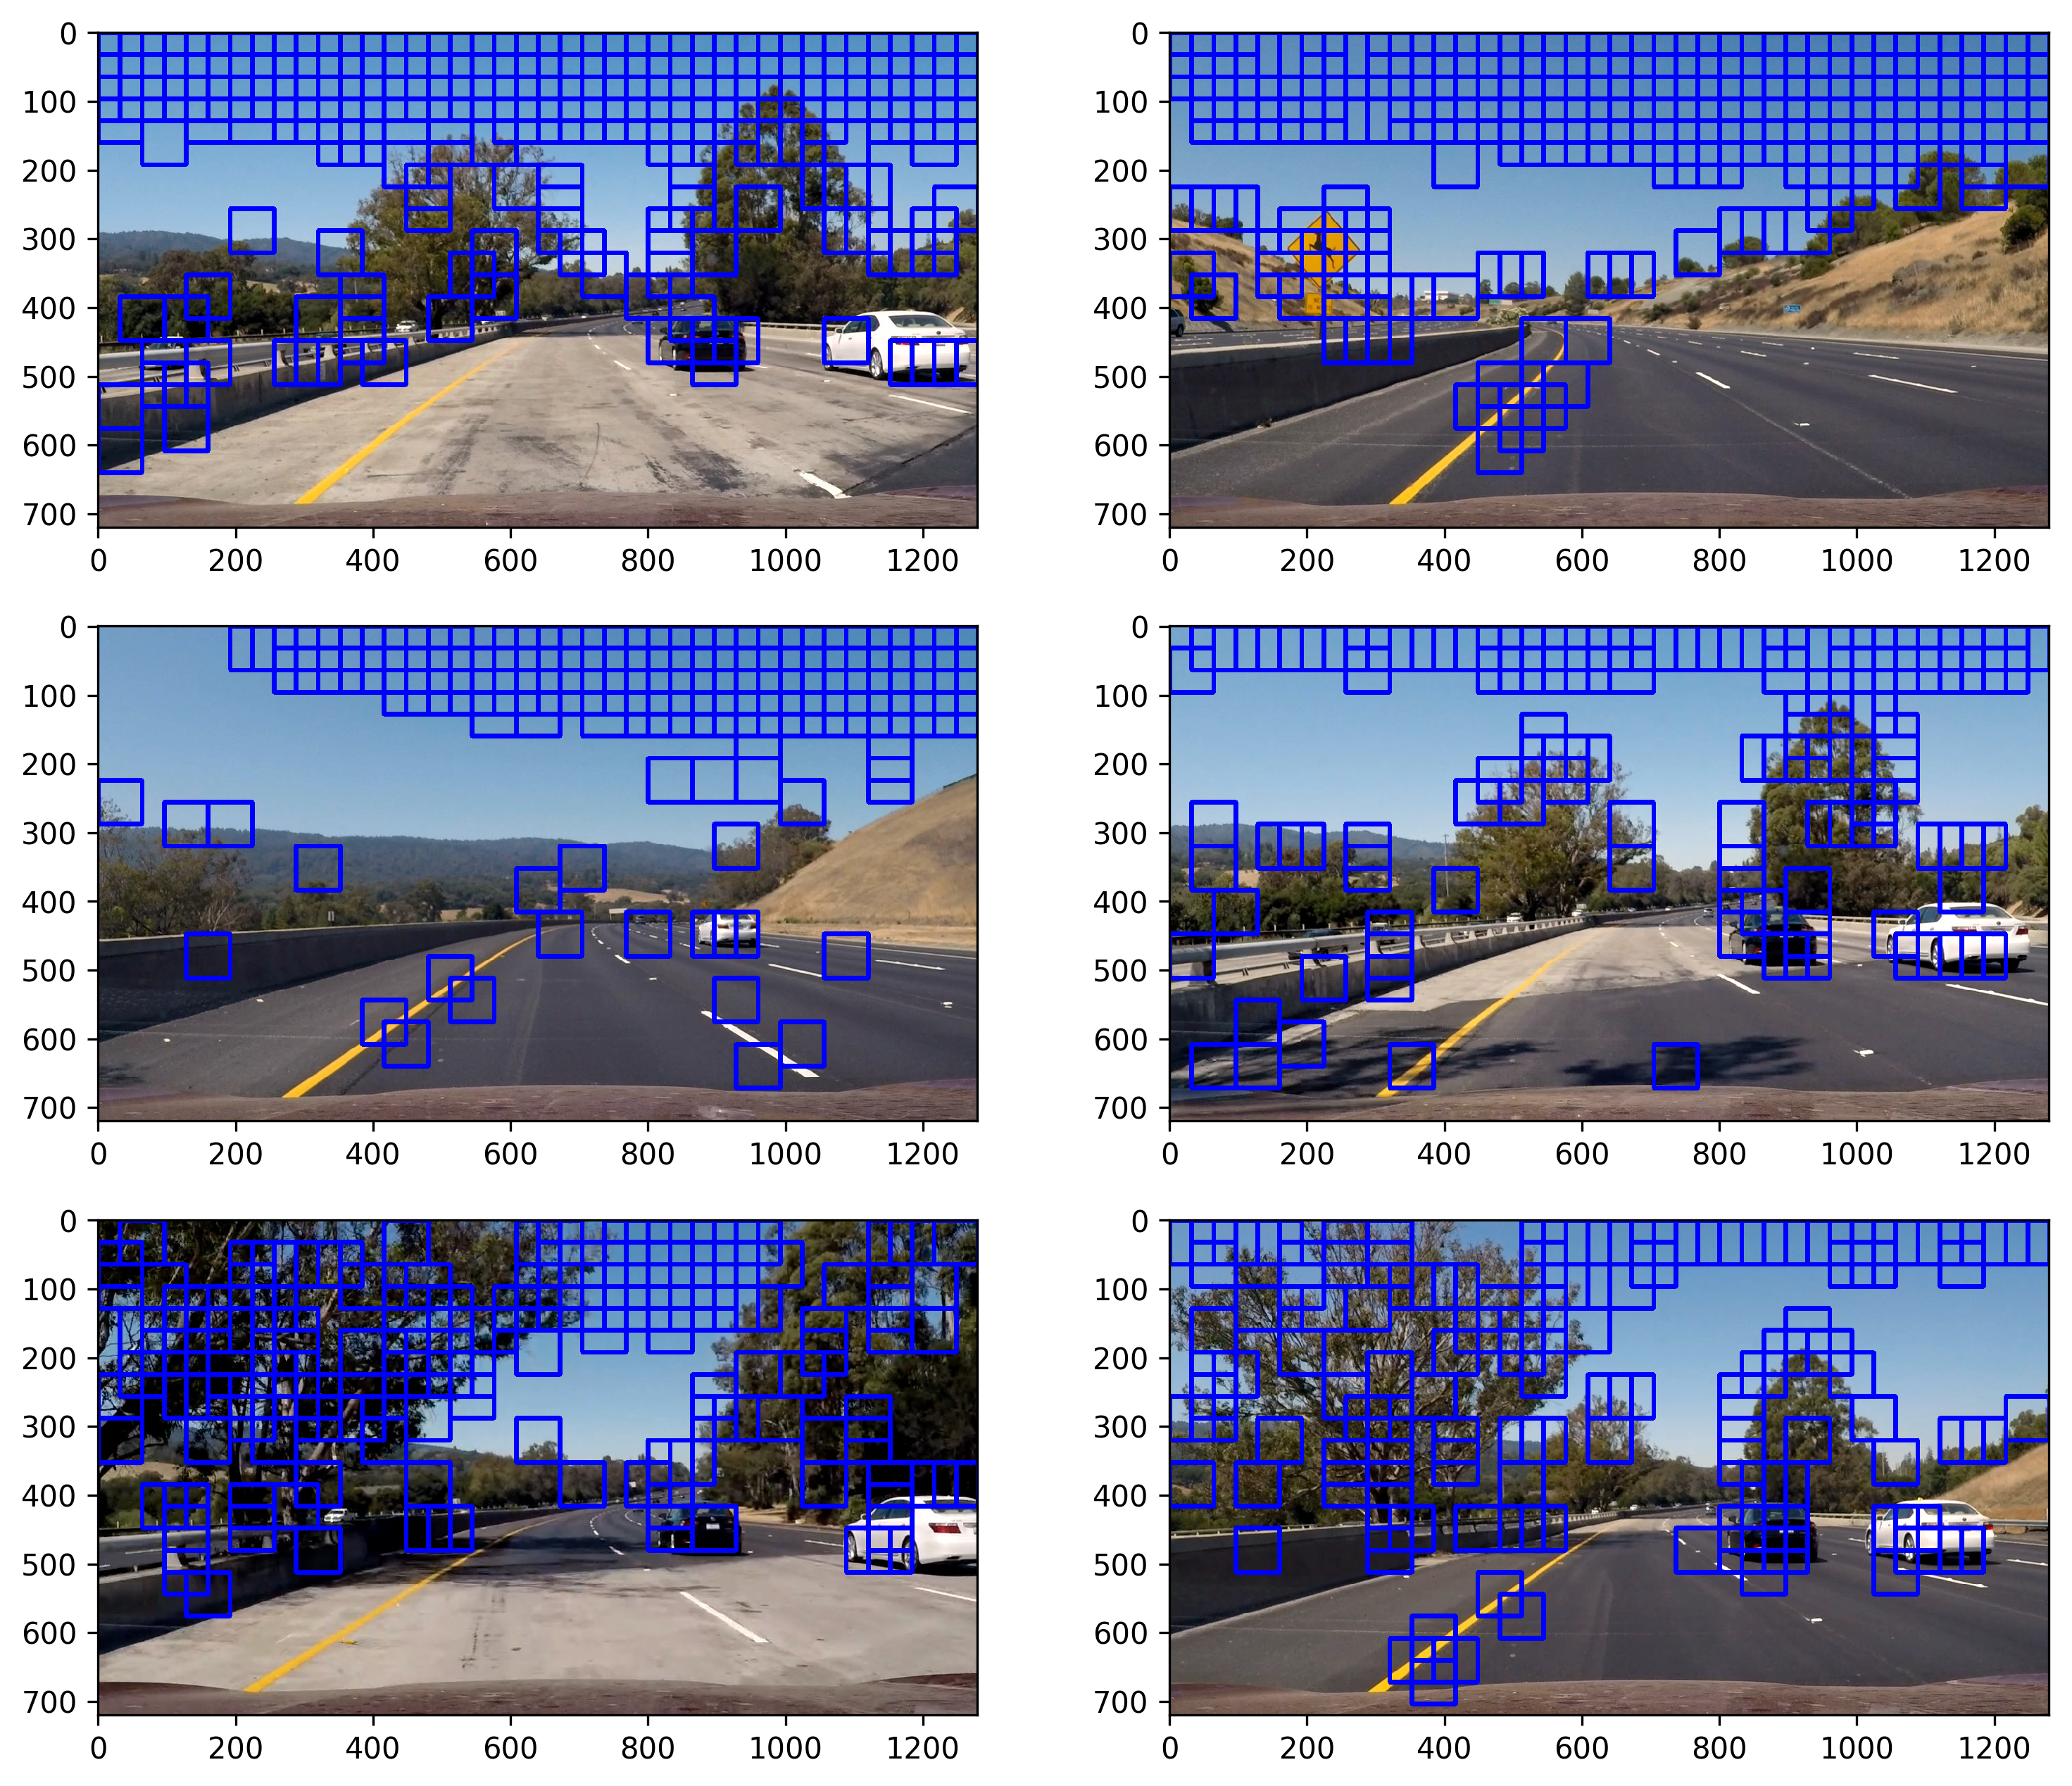

In [14]:
searchpath = 'test_images/*'
test_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [None, None]
overlap = 0.5
for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img, np.max(img)))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(64,64), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, x_scaler, cspace=colour_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5,2, images, titles)

In [18]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)

    labels = label(heat_map)
    
    draw_img  = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualise(fig, 8, 2, out_images, out_titles)

ValueError: operands could not be broadcast together with shapes (1,2004) (768,) (1,2004) 

In [ ]:
def pipeline(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    
    draw_img = draw_labled_bboxes(np.copy(img),labels)
    return draw_img

In [ ]:
from moviepy.editro import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(pipeline)
test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))

In [ ]:
class Vehicle():
    def _init_(self):
        self.detected = False
        self.n_detections = 0
        self.n_nondetections = 0
        self.xpixels = None
        self.ypixels = None
        self.recent_xfitted = []
        self.bestx = None
        self.recent_yfitted = []
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None
        self.recent_hfitted = []
        self.besth = None

In [ ]:
carslist = []
carslist.append(Vehicle())